# 0. GPU Setting

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

/Users/s2hee/opt/anaconda3/envs/sehee/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(5,5)
 
    def forward(self,x):
        net = self.lin1(x)
        return net

In [3]:
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
print(f"device: {device}")

device: mps


In [4]:
# MPS 장치에 바로 tensor를 생성합니다.
x = torch.ones(5, device=device)
 
# GPU 상에서 연산 진행
y = x * 2
 
# 또는, 다른 장치와 마찬가지로 MPS로 이동할 수도 있습니다.
model = Net()# 어떤 모델의 객체를 생성한 뒤,
model.to(device) # MPS 장치로 이동합니다.
 
# 이제 모델과 텐서를 호출하면 GPU에서 연산이 이뤄집니다.
pred = model(x)
print(pred)

tensor([ 0.6821,  0.3611, -0.3957, -0.1938, -0.1257], device='mps:0',
       grad_fn=<LinearBackward0>)


/Users/s2hee/opt/anaconda3/envs/sehee/lib/python3.9/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1667808783679/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


In [5]:
print (f"PyTorch version:{torch.__version__}") # 1.12.1 이상
print(f"MPS 장치를 지원하도록 build 되었는지: {torch.backends.mps.is_built()}") # True 여야 합니다.
print(f"MPS 장치가 사용 가능한지: {torch.backends.mps.is_available()}") # True 여야 합니다.
!python -c 'import platform;print(platform.platform())'

PyTorch version:1.14.0.dev20221107
MPS 장치를 지원하도록 build 되었는지: True
MPS 장치가 사용 가능한지: True
macOS-10.16-x86_64-i386-64bit


# 1. Basic U-Net Model Segmentation

In [6]:
import os
import random
from sklearn.model_selection import train_test_split
import torchvision.transforms.functional as TF

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2

import numpy as np
import matplotlib.pyplot as plt

In [7]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def cont_block(self, in_channels, out_channels, kernel_size=3):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                                        kernel_size=kernel_size, padding=1),
                              nn.ReLU(),
                              nn.Dropout2d(), # p=0.5
                              nn.Conv2d(in_channels=out_channels, out_channels=out_channels, 
                                        kernel_size=kernel_size, padding=1),
                              nn.ReLU(),
                              nn.BatchNorm2d(out_channels))
        return block
    
    def expn_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=mid_channel,
                                        kernel_size=kernel_size, padding=1),
                              nn.ReLU(),
                              nn.Dropout2d(),
                              nn.Conv2d(in_channels=mid_channel, out_channels=mid_channel,
                                        kernel_size=kernel_size, padding=1),
                              nn.ReLU(),
                              nn.BatchNorm2d(mid_channel),
                              nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels,
                                                 kernel_size=kernel_size, stride=2, padding=1, output_padding=1))
        return block
    
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=mid_channel,
                                        kernel_size=kernel_size, padding=1),
                              nn.ReLU(),
                              nn.Dropout2d(),
                              nn.Conv2d(in_channels=mid_channel, out_channels=mid_channel,
                                        kernel_size=kernel_size, padding=1),
                              nn.ReLU(),
                              nn.BatchNorm2d(mid_channel),
                              nn.Conv2d(in_channels=mid_channel, out_channels=out_channels,
                                        kernel_size=kernel_size, padding=1),
                              nn.Sigmoid()
                              )
        return block
    
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        self.contl_1 = self.cont_block(in_channels=in_channel, out_channels=64)
        self.contl_1_mp = nn.MaxPool2d(kernel_size=2)
        self.contl_2 = self.cont_block(in_channels=64, out_channels=128)
        self.contl_2_mp = nn.MaxPool2d(kernel_size=2)
        self.contl_3 = self.cont_block(in_channels=128, out_channels=256)
        self.contl_3_mp = nn.MaxPool2d(kernel_size=2)
        self.contl_4 = self.cont_block(in_channels=256, out_channels=512)
        self.contl_4_mp = nn.MaxPool2d(kernel_size=2)
        
        self.bottleneck = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=1024, 
                                                  kernel_size=3, padding=1),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(1024),
                                        nn.Conv2d(in_channels=1024, out_channels=1024, 
                                                  kernel_size=3, padding=1),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(1024),
                                        nn.ConvTranspose2d(in_channels=1024, out_channels=512,
                                                           kernel_size=3, stride=2, padding=1, output_padding=1)
                                        )
        
        self.expnl_1 = self.expn_block(1024, 512, 256)
        self.expnl_2 = self.expn_block(512, 256, 128)
        self.expnl_3 = self.expn_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)
    
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        contl_1_out = self.contl_1(x) 
        contl_1_pool = self.contl_1_mp(contl_1_out)
        contl_2_out = self.contl_2(contl_1_pool)
        contl_2_pool = self.contl_2_mp(contl_2_out)
        contl_3_out = self.contl_3(contl_2_pool)
        contl_3_pool = self.contl_3_mp(contl_3_out)
        contl_4_out = self.contl_4(contl_3_pool)
        contl_4_pool = self.contl_4_mp(contl_4_out)
        
        bottleneck_out = self.bottleneck(contl_4_pool)
        
        """ Skip connection of the expansive sub-module """
        expnl_1_cat = self.crop_and_concat(bottleneck_out, contl_4_out)
        expnl_1_out = self.expnl_1(expnl_1_cat)
        expnl_2_cat = self.crop_and_concat(expnl_1_out, contl_3_out)
        expnl_2_out = self.expnl_2(expnl_2_cat)
        expnl_3_cat = self.crop_and_concat(expnl_2_out, contl_2_out)
        expnl_3_out = self.expnl_3(expnl_3_cat)
        final_cat = self.crop_and_concat(expnl_3_out, contl_1_out)
        final_out = self.final_layer(final_cat)
        
        return final_out

In [8]:
# iou definition
def iou(pred, target, n_classes = 2):
    
    iou = []
    pred = pred.view(-1)
    target = target.view(-1)

    # Ignore IoU for background class ("0")
    for cls in range(1, n_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds[target_inds]).long().sum().data.cpu().item()
        union = pred_inds.long().sum().data.cpu().item() + target_inds.long().sum().data.cpu().item() - intersection

        if union == 0:
            iou.append(float('nan'))  # If there is no ground truth, do not include in evaluation
        else:
            iou.append(float(intersection) / float(max(union, 1)))

    return sum(iou)

In [9]:
import numpy as np
def iou_metric(y_pred, y_true, n_classes = 2):
    miou = []
    for i in np.arange(0.5, 1.0, 0.05):
        y_pred_ = (y_pred > i)
        iou_init = iou(y_pred_, y_true, n_classes = n_classes)
        miou.append(iou_init)
    
    return sum(miou)/len(miou)

In [10]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

In [11]:
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
print(f"device: {device}")

device: mps


In [12]:
x_train = np.load('x_train_v2.npy')
y_train = np.load('y_train_v2.npy')
x_val = np.load('x_val_v2.npy')
y_val = np.load('y_val_v2.npy')

# 2. Data Augmentation 없이 학습하기

In [13]:
# Data augmentation 없이 학습하기

class UNetDataset(Dataset):
    def __init__(self, images_np, masks_np):
        self.images_np = images_np
        self.masks_np = masks_np
    
    def transform(self, image_np, mask_np):
        ToPILImage = transforms.ToPILImage()
        image = ToPILImage(image_np)
        mask = ToPILImage(mask_np.astype(np.int32))
        
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask

    def __len__(self):
        return len(self.images_np)
    
    def __getitem__(self, idx):
        image_np = self.images_np[idx]
        mask_np = self.masks_np[idx]
        image, mask = self.transform(image_np, mask_np)
        
        return image, mask

In [14]:
train_dataset = UNetDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataset = UNetDataset(x_val, y_val)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

In [15]:
model = UNet(in_channel=3, out_channel=1).to(device)
print(model)

UNet(
  (contl_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.5, inplace=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (contl_1_mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (contl_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.5, inplace=False)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (contl_2_mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (contl_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): 

In [16]:
epochs = 25
alpha = 5
batch_size = 16
criterion=nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_iou_sum = 0
valid_iou_sum = 0

In [17]:
train_loss_list = []
val_loss_list = []
train_iou_list = []
val_iou_list = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_iou = 0

    i = 1
    for image, mask in train_loader:
        image = image.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        outputs = model(image.float())
    
        loss = criterion(outputs.float(), mask.float())
        train_loss += loss

        train_iou += iou_metric(outputs, mask)
        #print('[[ train',i,']] loss:',loss,'/ mAP:',iou_metric(outputs, mask))
        #i += 1
        rev_iou = 16 - iou_metric(outputs, mask)
        loss += alpha * rev_iou

        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        valid_loss = 0
        valid_iou = 0

        i = 1
        for image_val, mask_val in valid_loader:
            image_val = image_val.to(device)
            mask_val = mask_val.to(device)
            output_val = model(image_val.float())
            valid_loss += criterion(output_val.float(), mask_val.float())
            valid_iou += iou_metric(output_val, mask_val)
            #print('[[ train',i,']] loss:',criterion(output_val.float(), mask_val.float()),'/ mAP:',iou_metric(output_val, mask_val))
            i += 1

    #print('------------------------------------------------------------------')
    print("Epoch ", epoch + 1, " Training Loss: ", train_loss/len(train_loader), "Validation Loss: ", valid_loss/len(valid_loader))
    print("Training mAP: ", train_iou/len(train_loader), "Validation mAP: ", valid_iou/len(valid_loader))
    train_iou_sum += train_iou/len(train_loader)
    valid_iou_sum += valid_iou/len(valid_loader)

    # visualization
    train_loss_list.append(train_loss/len(train_loader))
    val_loss_list.append(valid_loss/len(valid_loader))
    train_iou_list.append(train_iou/len(train_loader))
    val_iou_list.append(valid_iou/len(valid_loader)
)
    
print("Training Mean mAP: {:.2f}".format(train_iou_sum/epochs), " Validation Mean mAP: {:.2f}".format(valid_iou_sum/epochs))

Epoch  1  Training Loss:  tensor(0., device='mps:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0., device='mps:0')
Training mAP:  0.06630943569487202 Validation mAP:  0.03029341511526429
Epoch  2  Training Loss:  tensor(0., device='mps:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0., device='mps:0')
Training mAP:  0.06675968710139528 Validation mAP:  0.027317055488623117
Epoch  3  Training Loss:  tensor(0., device='mps:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0., device='mps:0')
Training mAP:  0.0664363475538995 Validation mAP:  0.03201721189609993
Epoch  4  Training Loss:  tensor(0., device='mps:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0., device='mps:0')
Training mAP:  0.06546217309509579 Validation mAP:  0.030057922128469437
Epoch  5  Training Loss:  tensor(0., device='mps:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0., device='mps:0')
Training mAP:  0.06660504015589508 Validation mAP:  0.032205227767074365
Epoch  6  Training Loss:  te

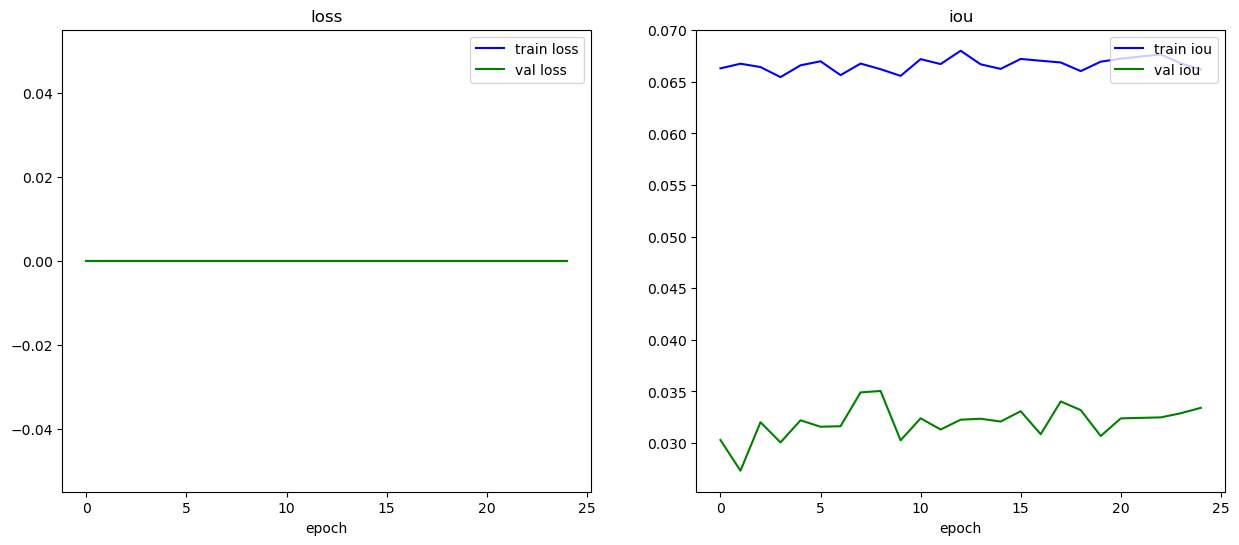

In [18]:
# Loss, IOU 값 시각화하기

train_loss_data = [i.detach().cpu().numpy() for i in train_loss_list]
val_loss_data = [i.detach().cpu().numpy() for i in val_loss_list]
# train_iou_data = [i.detach().cpu().numpy() for i in train_iou_list]
# val_iou_data = [i.detach().cpu().numpy() for i in val_iou_list]

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6)) 
plt.subplot(1,2,1)
plt.title('loss')
plt.xlabel('epoch')
plt.plot(train_loss_data, 'b', label='train loss')
plt.plot(val_loss_data, 'g', label='val loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.title('iou')
plt.xlabel('epoch')
plt.plot(train_iou_list, 'b', label='train iou')
plt.plot(val_iou_list, 'g', label='val iou')
plt.legend(loc='upper right')

plt.show()

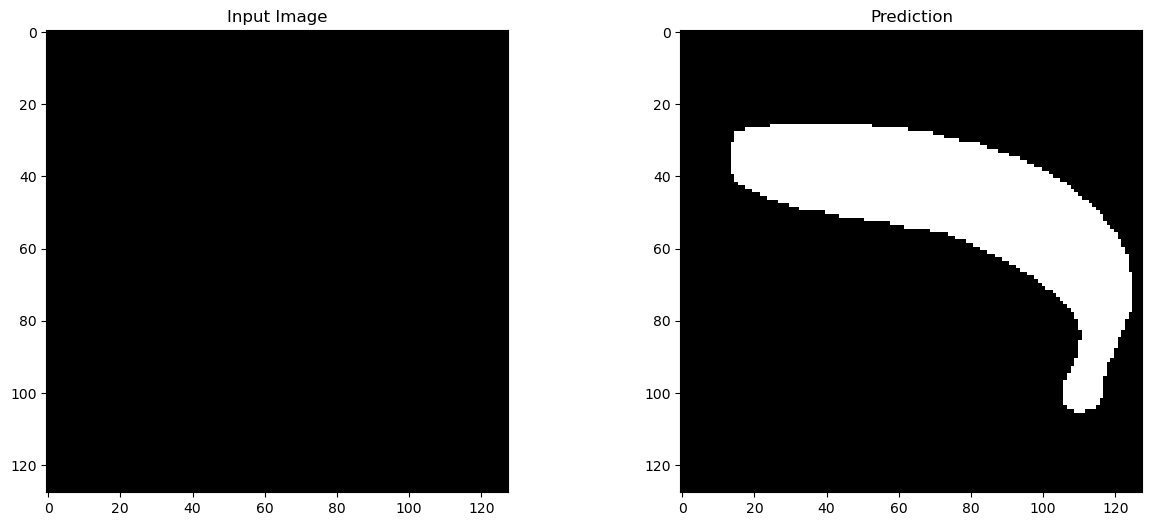

In [20]:
# 실제값, 예측값 시각화하기

for img_, mask_ in valid_loader:
    img = img_[1].to(device)
    img.unsqueeze_(0)
    mask_pred = model(img.float())
    mask_pred = mask_pred.cpu()
    mask_pred = (mask_pred > 0.75)
    mask_true = mask_[1]

    img = TF.to_pil_image(mask_pred.float().squeeze(0))
    mask = TF.to_pil_image(mask_true)

    img = np.array(img)
    mask = np.array(mask)

    fig, (axis_1, axis_2) = plt.subplots(1, 2, figsize=(15, 6))
    axis_1.imshow(img.astype(np.uint8), cmap='gray')
    axis_1.set_title('Input Image')
    axis_2.imshow(mask.astype(np.uint8), cmap='gray')
    axis_2.set_title('Prediction')
    plt.show()

    break

# 3. Data Augmentation 적용하여 학습하기

In [17]:
# Data augmentation 적용하여 학습하기

class UNetDataset_DAug(Dataset):
    def __init__(self, images_np, masks_np):
        self.images_np = images_np
        self.masks_np = masks_np
    
    def transform(self, image_np, mask_np):
        ToPILImage = transforms.ToPILImage()
        image = ToPILImage(image_np)
        mask = ToPILImage(mask_np.astype(np.int32))
        
        image = TF.pad(image, padding = 20, padding_mode = 'reflect')
        mask = TF.pad(mask, padding = 20, padding_mode = 'reflect')
              
        angle = random.uniform(-10, 10)
        width, height = image.size
        max_dx = 0.1 * width
        max_dy = 0.1 * height
        translations = (np.round(random.uniform(-max_dx, max_dx)), np.round(random.uniform(-max_dy, max_dy)))
        scale = random.uniform(0.8, 1.2)
        shear = random.uniform(-0.5, 0.5)
        image = TF.affine(image, angle = angle, translate = translations, scale = scale, shear = shear)
        mask = TF.affine(mask, angle = angle, translate = translations, scale = scale, shear = shear)
        

        image = TF.center_crop(image, (128, 128))
        mask = TF.center_crop(mask, (128, 128))
        
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask

    def __len__(self):
        return len(self.images_np)
    
    def __getitem__(self, idx):
        image_np = self.images_np[idx]
        mask_np = self.masks_np[idx]
        image, mask = self.transform(image_np, mask_np)
        
        return image, mask

In [18]:
x_train = np.load('x_train_v3.npy')
y_train = np.load('y_train_v3.npy')
x_val = np.load('x_val_v3.npy')
y_val = np.load('y_val_v3.npy')

In [19]:
train_dataset = UNetDataset_DAug(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataset = UNetDataset_DAug(x_val, y_val)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

In [20]:
model2 = UNet(in_channel=3, out_channel=1).to(device)
print(model2)

UNet(
  (contl_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.5, inplace=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (contl_1_mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (contl_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.5, inplace=False)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (contl_2_mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (contl_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): 

In [21]:
epochs = 25 
alpha = 5
batch_size = 16 
criterion=nn.BCELoss()
optimizer = optim.Adam(model2.parameters(), lr=1e-3)
train_iou_sum = 0
valid_iou_sum = 0

In [22]:
train_loss_list = []
val_loss_list = []
train_iou_list = []
val_iou_list = []

for epoch in range(epochs):
    model2.train()
    train_loss = 0
    train_iou = 0

    for image, mask in train_loader:
        image = image.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        outputs = model2(image.float())
    
        loss = criterion(outputs.float(), mask.float())
        train_loss += loss

        train_iou += iou_metric(outputs, mask)
        rev_iou = 16 - iou_metric(outputs, mask)
        loss += alpha * rev_iou

        loss.backward()
        optimizer.step()

    model2.eval()
    with torch.no_grad():
        valid_loss = 0
        valid_iou = 0

        for image_val, mask_val in valid_loader:
            image_val = image_val.to(device)
            mask_val = mask_val.to(device)
            output_val = model2(image_val.float())
            valid_loss += criterion(output_val.float(), mask_val.float())
            valid_iou += iou_metric(output_val, mask_val)

    print("Epoch ", epoch + 1, " Training Loss: ", train_loss/len(train_loader), "Validation Loss: ", valid_loss/len(valid_loader))
    print("Training mAP: ", train_iou/len(train_loader), "Validation mAP: ", valid_iou/len(valid_loader))
    train_iou_sum += train_iou/len(train_loader)
    valid_iou_sum += valid_iou/len(valid_loader)

    # visualization
    train_loss_list.append(train_loss/len(train_loader))
    val_loss_list.append(valid_loss/len(valid_loader))
    train_iou_list.append(train_iou/len(train_loader))
    val_iou_list.append(valid_iou/len(valid_loader)
)
    
print("Training Mean mAP: {:.2f}".format(train_iou_sum/epochs), " Validation Mean mAP: {:.2f}".format(valid_iou_sum/epochs))

Epoch  1  Training Loss:  tensor(0.4970, device='mps:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.4427, device='mps:0')
Training mAP:  0.2136453395769053 Validation mAP:  0.20245236185828336
Epoch  2  Training Loss:  tensor(0.4506, device='mps:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.4208, device='mps:0')
Training mAP:  0.22386644577755974 Validation mAP:  0.21234495625341335
Epoch  3  Training Loss:  tensor(0.4300, device='mps:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.3952, device='mps:0')
Training mAP:  0.2650089429412591 Validation mAP:  0.30546476869692535
Epoch  4  Training Loss:  tensor(0.4118, device='mps:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.3813, device='mps:0')
Training mAP:  0.29252557434185744 Validation mAP:  0.2597165282812678
Epoch  5  Training Loss:  tensor(0.3855, device='mps:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.3442, device='mps:0')
Training mAP:  0.33024241257402887 Validation mAP:  0.35354157617

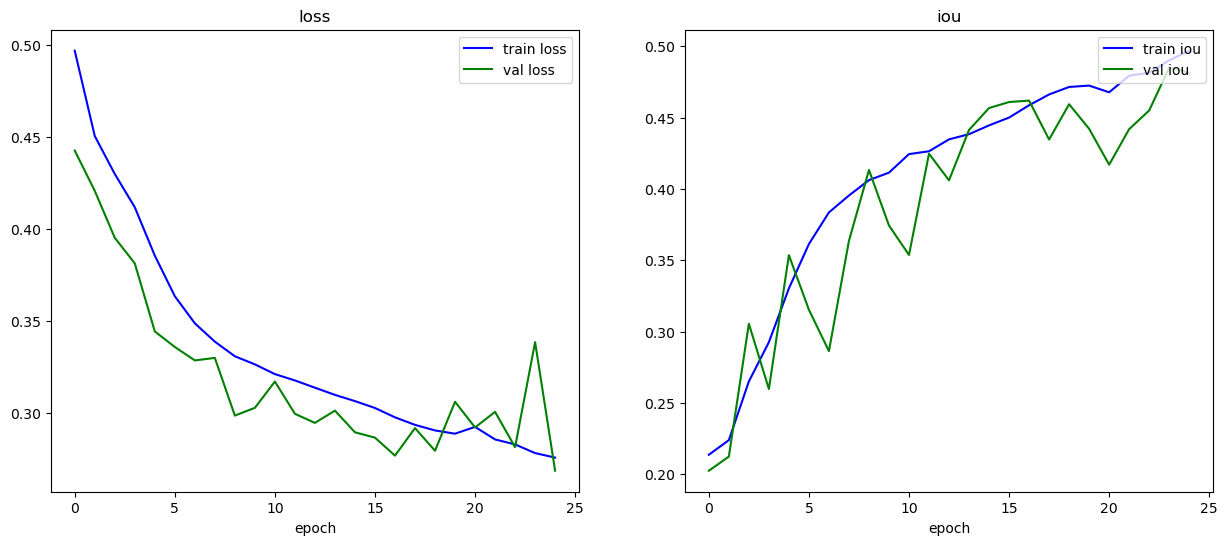

In [23]:
# Loss, IOU 값 시각화

train_loss_data = [i.detach().cpu().numpy() for i in train_loss_list]
val_loss_data = [i.detach().cpu().numpy() for i in val_loss_list]
# train_iou_data = [i.detach().cpu().numpy() for i in train_iou_list]
# val_iou_data = [i.detach().cpu().numpy() for i in val_iou_list]

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6)) 
plt.subplot(1,2,1)
plt.title('loss')
plt.xlabel('epoch')
plt.plot(train_loss_data, 'b', label='train loss')
plt.plot(val_loss_data, 'g', label='val loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.title('iou')
plt.xlabel('epoch')
plt.plot(train_iou_list, 'b', label='train iou')
plt.plot(val_iou_list, 'g', label='val iou')
plt.legend(loc='upper right')

plt.show()

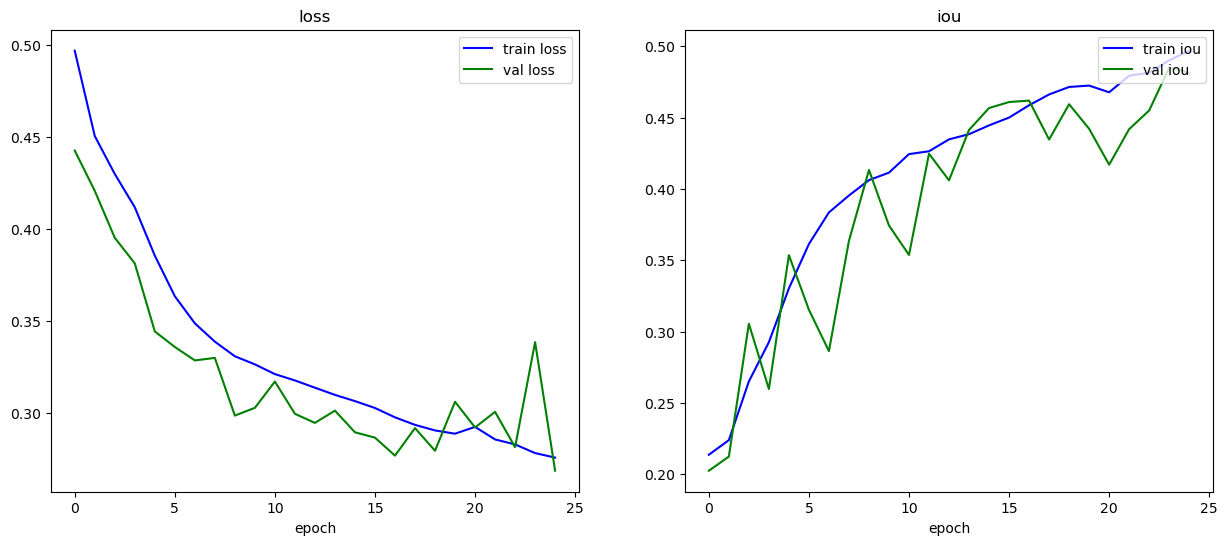

In [24]:
# Loss, IOU 값 시각화

train_loss_data = [i.detach().cpu().numpy() for i in train_loss_list]
val_loss_data = [i.detach().cpu().numpy() for i in val_loss_list]
# train_iou_data = [i.detach().cpu().numpy() for i in train_iou_list]
# val_iou_data = [i.detach().cpu().numpy() for i in val_iou_list]

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6)) 
plt.subplot(1,2,1)
plt.title('loss')
plt.xlabel('epoch')
plt.plot(train_loss_data, 'b', label='train loss')
plt.plot(val_loss_data, 'g', label='val loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.title('iou')
plt.xlabel('epoch')
plt.plot(train_iou_list, 'b', label='train iou')
plt.plot(val_iou_list, 'g', label='val iou')
plt.legend(loc='upper right')

plt.show()

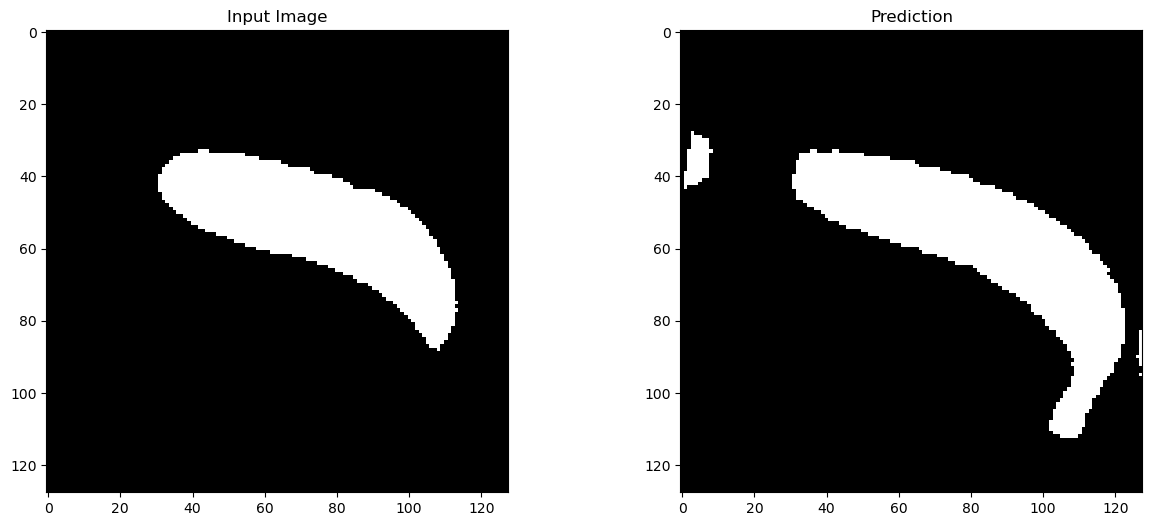

In [25]:
# Test 실제값, 예측값 시각화

for img_, mask_ in valid_loader:
    img = img_[1].to(device)
    img.unsqueeze_(0)
    mask_pred = model2(img.float())
    mask_pred = mask_pred.cpu()
    mask_pred = (mask_pred > 0.75)
    mask_true = mask_[1]

    img = TF.to_pil_image(mask_pred.float().squeeze(0))
    mask = TF.to_pil_image(mask_true)

    img = np.array(img)
    mask = np.array(mask)

    fig, (axis_1, axis_2) = plt.subplots(1, 2, figsize=(15, 6))
    axis_1.imshow(img.astype(np.uint8), cmap='gray')
    axis_1.set_title('Input Image')
    axis_2.imshow(mask.astype(np.uint8), cmap='gray')
    axis_2.set_title('Prediction')
    plt.show()

    break